## Compute grand-canonical averages

Use the following functions to:

   1) compute the maximum-likelihood partition functions of buffer $\Omega_B$ and binding $\Omega_A$ regions
   
   2) estimate the chemical potential $\mu$ as a function of the number of particles $N_B$ in the buffer region $B$
   
   3) compute grand-canonical averages

In [1]:
# Import required modules

import numpy as np
import pickle as pkl
import mdtraj as md

### 1) Compute $\Omega_A$ and $\Omega_B$

In [2]:
# Normalization step

def normalize(OA,OB):
    
    A=+np.array(OA)
    B=+np.array(OB)
    
    for k in range(len(A)): # this runs over the number of all possibile combinations of particle states
        if A[k]!=0:
            A/=A[k]
            break
            
    for k in range(len(B)):
        if B[k]!=0:
            B/=B[k]
            factor=B[k+1]/B[k]
            break
            
    for k in range(len(B)):
        B[k]/=factor**k
        
    for k in range(len(A)):
        A[k]/=factor**k
        
    return A,B

In [3]:
# Estimation step  

def iterate(A,B,L,OA,OB):
    
    # Initialize partition functions
    
    if OA is None:
        OA=+A
        OA=np.ones(len(A))
    
    if OB is None:
        OB=+B
        OB=np.ones(len(B))
    
    # Find normalization factors first:
    
    C={}
    for N in L.keys():
        s=0
        for k in range(len(OA)):
            if N-k>=0 and N-k<len(OB): # outside of bounds, OA and OB are implicitely zero
                s+=OA[k]*OB[N-k]
        C[N]=1.0/s
        
    # Update OA

    OA_new=np.zeros(len(OA))
    for k in range(len(OA)):
        s=0
        for N in L.keys():
            if N-k>=0 and N-k<len(OB): # outside of bounds, OB is implicitely zero
                s+=L[N]*C[N]*OB[N-k]
        if A[k]==0:
            OA_new[k]=0.0
        else:
            OA_new[k]=A[k]/s
     
    # Update OB
    
    OB_new=np.zeros(len(OB))
    for k in range(len(OB)):
        s=0
        for N in L.keys():
            if N-k>=0 and N-k<len(OA): # outside of bounds, OA is implicitely zero
                s+=L[N]*C[N]*OA[N-k]
        if B[k]==0:
            OB_new[k]=0.0
        else:
            OB_new[k]=B[k]/s
            
    # Normalize for plotting:
    
    eps = np.sum((OA_new-OA)**2)+np.sum((OB_new-OB)**2)
    OA_new,OB_new = normalize(OA_new,OB_new)
    
    return OA_new,OB_new,eps

In [4]:
# Running routine

def solve(A,B,L,threshold = 1e-10, max_n_steps = 1000):
    
    # Initialize partition functions
    
    OA,OB = None,None
    
    for i in range(max_n_steps):
        
        OA,OB,eps = iterate(A,B,L,OA,OB)
                
        if(eps < threshold):
            print("Iteration at convergency\t eps")
            print(i,"\t",eps)
            break
    
    return OA,OB

#### Example

In [5]:
# Load file binding tensor obtained with compute_bindings.ipynb

bindings = pkl.load(open("../data/example_data/other/bindings_2.9_0.35.dat", "rb"))

# Compute number of frames with k particles in binding region A, for each k in 1,..,N

A = np.sum(np.sum(bindings, axis=(0,5,6))[0,0], axis=1)

# Compute number of frames with k particles in buffer region B, for each k in 1,..,N

B = np.sum(np.sum(bindings, axis=(0,5,6))[0,0], axis=0)

# Compute total number of frames from each trajectory at fixed N

L = dict((N+1,LN) for N,LN in enumerate(np.sum(np.sum(bindings[:,0,0,:], axis=(3,4))[:], axis=(1,2))))

# Run the routine to compute partition functions

OA,OB = solve(A,B,L,1e-30)

Iteration at convergency	 eps
126 	 3.590424343304825e-31


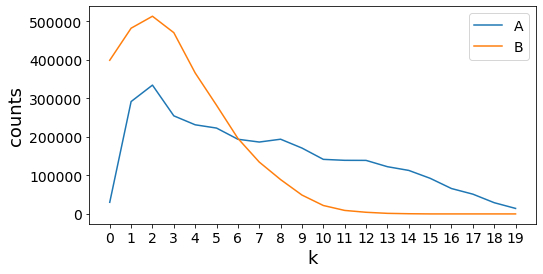

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(A, '-', label='A')
plt.plot(B, '-', label = 'B')
plt.xticks(list(range(20)), fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('counts', fontsize=18)
plt.xlabel('k', fontsize=18)
plt.legend(fontsize=14)
plt.show()

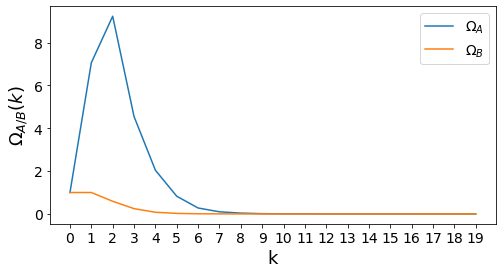

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(OA, '-', label = r'$\Omega_A$')
plt.plot(OB, '-', label = r'$\Omega_B$')
plt.xticks(list(range(20)), fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(r'$\Omega_{A/B}(k)$', fontsize=18)
plt.xlabel('k', fontsize=18)
plt.legend(fontsize=14)
plt.show()

### 2) Compute $\mu(N_B)$

In [8]:
def find_mu(mu,OB,NB):
    P =+ OB
    for k in range(len(P)):
        P[k]*=np.exp(-mu*k)
    P/=np.sum(P)
    NB_estimate=np.sum(P*range(len(P)))
    return np.log(NB)-np.log(NB_estimate)

#### Example

In [9]:
# Estimate average box volume from trajectories
# here on example data:

volumes = np.array([])

for nprobes in range(1,10):
    top = md.load_topology('../data/example_data/topologies/top_n'+str(nprobes)+'.gro')
    top = top.subset(top.select("(resname =~ '1M7') or (resname =~ 'A') or (resname =~ 'U') or (resname =~ 'C') or (resname =~ 'G')"))
    traj = md.load('../data/example_data/trajectories/traj_n'+str(nprobes)+'_reduced.xtc', top = top)
    volumes = np.concatenate((volumes, traj.unitcell_volumes))

In [10]:
# Convert average volume to liter units

vv = np.mean(volumes) ## average box volume
vvl = vv*1e-24 ## volume in L

# Set a range of reagent concentrations
c_exp = np.logspace(-6,-2,50)

# Compute corresponding number of particles in buffer region B

nav = 6.022*1e23  ## mol^{-1}
nb_exp = nav*vvl*c_exp

In [11]:
# Find values of the chemical potential corresponding to the chosen reagent concentration

import scipy.optimize as opt

mu = []

for nb in nb_exp:
    mu.append(opt.bisect(find_mu,-10,10,(OB,nb)))

/var/folders/qx/w0w1832s0tv15p2l6634z33c0000gn/T/ipykernel_19187/3688832984.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['','',r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'$10^{0}$',''],fontsize=16)
/var/folders/qx/w0w1832s0tv15p2l6634z33c0000gn/T/ipykernel_19187/3688832984.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['','',r'$10^{-6}$',r'$10^{-5}$',r'$10^{-4}$',r'$10^{-3}$',r'$10^{-2}$'],fontsize=16)


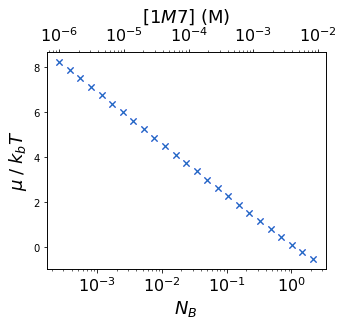

In [12]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(nb_exp[::2],mu[::2], 'bx')
ax1.set_xscale('log')
ax1.set_ylabel(r'$\mu\;/\;k_b T$', fontsize=18)
ax1.set_xlabel(r'$N_B$', fontsize=18)
ax1.set_xticklabels(['','',r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'$10^{0}$',''],fontsize=16)
ax2.plot(c_exp[::2],mu[::2],'x')
ax2.set_xlabel(r'$[1M7]$ (M)', fontsize=18)
ax2.set_xscale('log')
ax2.set_xticklabels(['','',r'$10^{-6}$',r'$10^{-5}$',r'$10^{-4}$',r'$10^{-3}$',r'$10^{-2}$'],fontsize=16)
plt.show()

### 3) Compute grand-canonical averages

In [13]:
def compute_gc_weights(A, # counts array of number of particles in binding region  
                       omega_A, # partition function of the binding region  
                       mu_values): # input values of chemical potential
    
    weights = np.zeros(((len(mu_values)),len(A)))
    
    for mm,mu in enumerate(mu_values):
        # compute and normalize weight
        h = np.exp(-mu*np.array(range(len(omega_A))))*omega_A
        h /= np.sum(h)
        # scale weight by the number of particles
        weights[mm] = h/A
        
    return weights

#### Example

In [14]:
# Compute weights using values computed in the previous examples

weights = compute_gc_weights(A,OA,mu)

In [15]:
bindings.shape

(19, 10, 10, 20, 20, 2, 2)

In [16]:
# Marginalize bindings tensor over trajectories and observed number of particles in buffer region

pp = np.sum(bindings, axis = (0,4))

# Exclude values of k (number of particles in binding region) observed in no frame

nonzeros = np.where(A != 0)[0]
pp[:,:,nonzeros,:,:] /= np.sum(pp,axis=(-2,-1))[:,:,nonzeros,np.newaxis,np.newaxis]

# Initialize weighted bindings

pp_w = np.zeros((len(mu),10,10,2,2))

In [17]:
# Compute weighted bindings and reactivities

reactivity = []

for mm,m in enumerate(mu):
    pp_w[mm] = np.einsum('ijklm,k->ijlm',pp[:,:,nonzeros,:,:],(weights*A)[:,nonzeros][mm])
    reactivity.append(np.sum(pp_w[mm], axis = 3)[:,0,1])
reactivity = np.array(reactivity)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


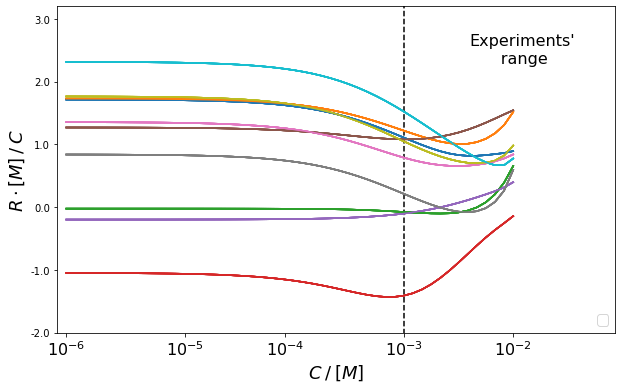

In [18]:
from matplotlib.ticker import FormatStrFormatter
x = np.log(c_exp)
y = np.log(reactivity/c_exp[:, None])
plt.figure(figsize=(10,6))
seq = ['G71','C72','G73','G74','A75','A76','A77','C78','G79','U80']
plt.ylabel(r'$R\cdot[M]\:/\:C$', fontsize=18)
plt.xlabel(r'$C\:/\:[M]$', fontsize=18)
plt.plot(-6.85*np.ones(2),[-10,10], 'k--')
plt.xticks([x[0],x[13],x[24],x[37],x[49]],labels=[r'$10^{-6}$',r'$10^{-5}$',r'$10^{-4}$',r'$10^{-3}$',r'$10^{-2}$'],fontsize=16)
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.text(-5.5,2.3,'Experiments\'\n      range', fontsize=16)
plt.ylim(-2.0,3.2)
plt.xlim(-14,-2.5)
for i in range(reactivity.shape[1]-2):
    plt.plot(x,y)
plt.legend(loc='lower right', fontsize=14)